### Objective - Apply Decision Tree on Amazon Fine Food Reviews

####  Importing modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from prettytable import PrettyTable
import random
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import validation_curve
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

#import nltk
#nltk.download('stopwords')

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#from gensim.models import KeyedVectors
#model = KeyedVectors.load_word2vec_format(‘GoogleNews-vectors-negative300.bin.gz’,binary=True)

#import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Loading data

In [3]:
con = sqlite3.connect('/Users/mohdsaquib/Documents/Data/database.sqlite') 

In [4]:
filtered_data  = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
print(filtered_data.shape)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)

(525814, 10)
(525814, 10)


In [5]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


### Sorting Data with respect to Product Id and droping Duplicates

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

### Preprocessing 

In [19]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [20]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"she's", 'there', 'her', 'be', 'against', 'than', 'which', 'most', 'couldn', 'ourselves', "you'd", 'to', 'should', 'between', 'down', "you'll", 'will', 't', 'his', 'haven', "that'll", 'yourself', 'here', 'because', 'what', "won't", 'through', 'but', 'when', 'below', 'o', 'themselves', "wasn't", 'those', 'all', 'theirs', 'at', 'wouldn', 'our', 'same', "mustn't", 'hers', 'being', 'while', 'now', 'some', 'we', 'each', 'if', 'yourselves', 'doing', 'herself', 'himself', 'mightn', "weren't", 'out', 'no', "aren't", 'and', 'have', 'having', "you've", 'she', 'ain', 'whom', "shan't", 'they', 'ours', 'it', 'shouldn', 'are', "didn't", 'has', 'i', 'do', 'on', 'll', 'after', 'before', 'don', 'y', 'why', 'how', 'does', 'mustn', 'by', 'd', 'again', 'm', 'itself', 'its', "needn't", "hasn't", 'who', 'had', 'a', 'only', 'needn', 'for', 'ma', 'myself', "isn't", 'aren', 'shan', 'weren', 'where', 'nor', 'or', "wouldn't", 'with', 'once', 'up', 'from', "hadn't", "should've", 'were', 'doesn', 'you', 'isn', 'r

In [21]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 60K sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [22]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
print(final.shape)

(364171, 11)


### Sorting the value with respecct to time

In [24]:
### sorting values with respect to time
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = X[:100000]
y = final['Score'].values
y = y[:100000]

In [201]:
#data splitting for bag of words
y_train=final['Score'][0:49000]
y_cv=final['Score'][49000:70000]
y_test=final['Score'][70000:100000]

In [202]:
X_train=final['CleanedText'][0:49000]
X_cv=final['CleanedText'][49000:70000]
X_test=final['CleanedText'][70000:100000]

### Bag of Words

In [203]:
### Bag of Words
count_vector = CountVectorizer()
bow_train = count_vector.fit_transform(X_train)
bow_cv  = count_vector.transform(X_cv)
bow_test= count_vector.transform(X_test)

In [204]:
print(bow_train.shape)
print(bow_cv.shape)
bow_test.shape


(49000, 26770)
(21000, 26770)


(30000, 26770)

### Decision Tree Classifier (Training)

In [214]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

l=np.arange(1,1000,36)


Depths=[1, 5, 10, 50, 100, 500, 1000]
min_split= [5, 10, 100, 500]

param_grid = {'max_depth': Depths, 'min_samples_split': min_split}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1, pre_dispatch=2)
model.fit(bow_train, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

#Optimal value of min_samples_split
optimal_split = model.best_estimator_.min_samples_split
print("The optimal value of min split is : ",optimal_split)



Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of depth is :  50
The optimal value of min split is :  500


### ROC-AUC of Train and CV

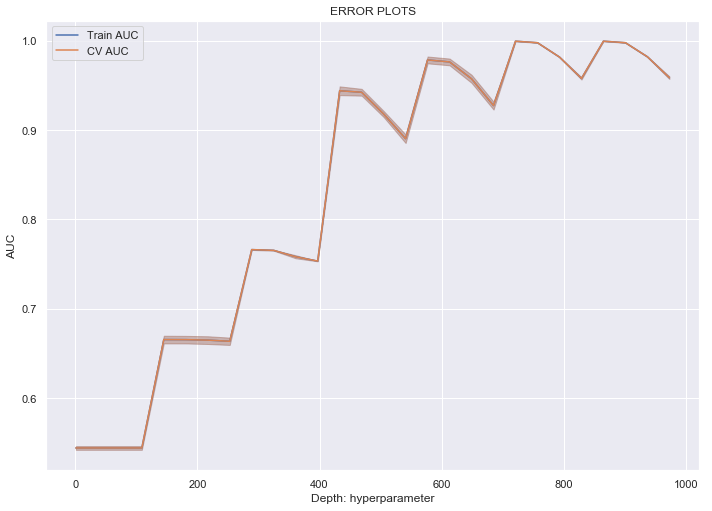

In [225]:
plt.plot(l, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

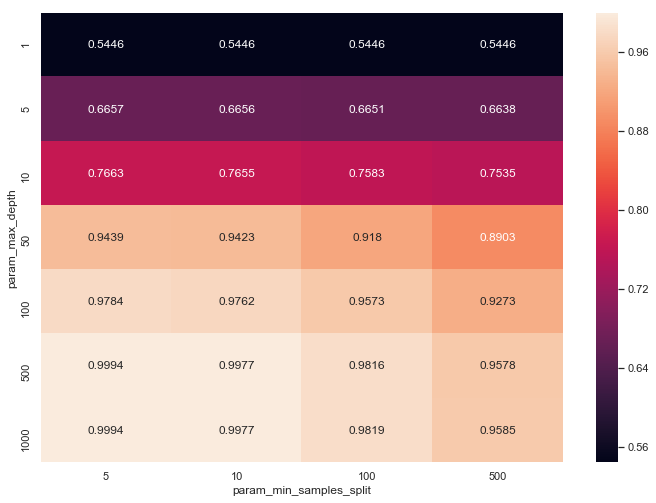

In [216]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')
plt.show()

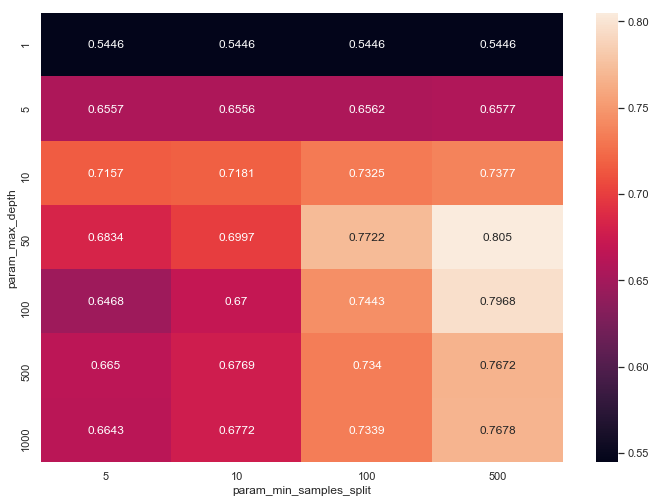

In [217]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()


In [227]:
results = pd.DataFrame(model.cv_results_)

In [228]:
results = results.sort_values(by='mean_test_score', ascending=False)

In [229]:
results[['mean_test_score', 'param_max_depth', 'param_min_samples_split']].round(3).head()

,mean_test_score,param_max_depth,param_min_samples_split
15,0.805,50,500
19,0.797,100,500
14,0.772,50,100
27,0.768,1000,500
23,0.767,500,500


In [230]:
model.best_score_

0.8049579904378342

### Observation -
#### *Optimal Depth = 50*

#### *Minimum split = 500*
#### *AUC CV = 0.80*


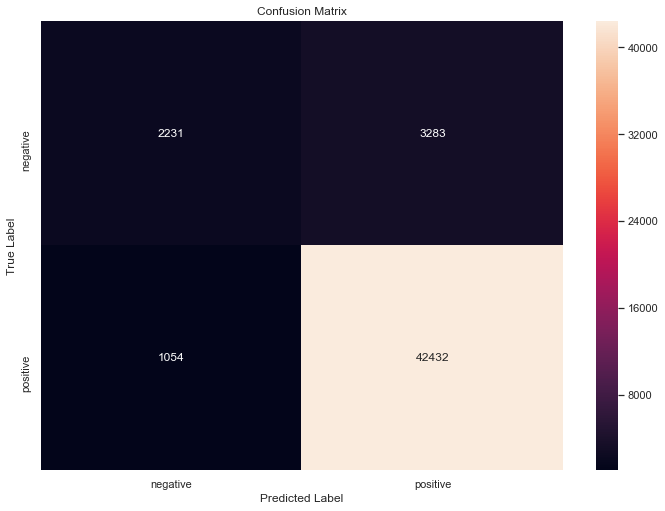

In [231]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
pred_train= model.predict(bow_train)
cm = confusion_matrix(y_train, pred_train)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation
#### The Confsuion Matrix for training shows that 2231 points are correclty classified as negative points, and 42432 points are classified correctly as positive points.

### Testing

In [232]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth= 50, min_samples_split= 500)
clf.fit(bow_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

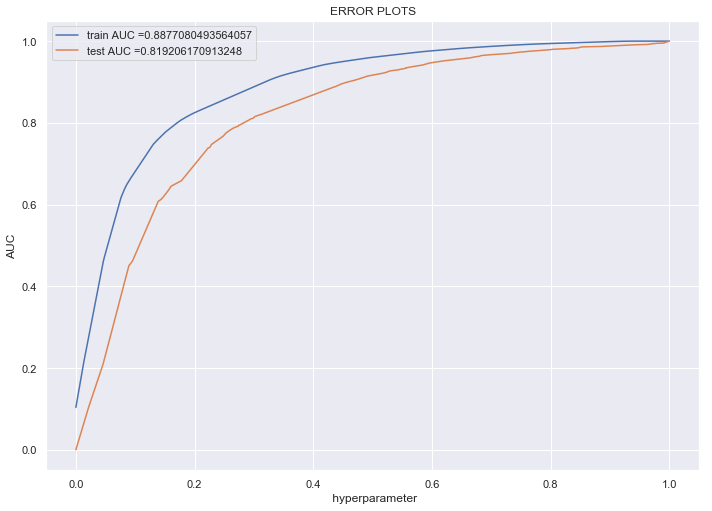

AUC value on test data: 0.819206170913248


In [233]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(bow_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(bow_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel(" hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
pred = clf.predict(bow_test)
pred_prob = clf.predict_proba(bow_test)[:,1]
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))


#### AUC Test = 0.81

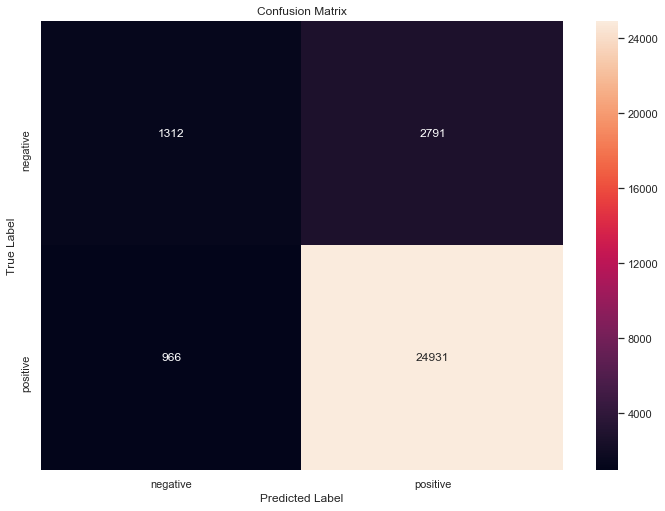

In [234]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
pred_test= model.predict(bow_test)
cm = confusion_matrix(y_test, pred_test)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation
#### The Confsuion Matrix for testing shows that 1312 points are correclty classified as negative points, and 24931 points are classified correctly as positive points.

### Classification Report

In [235]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.58      0.32      0.41      4103
          1       0.90      0.96      0.93     25897

avg / total       0.86      0.88      0.86     30000



### Graphviz

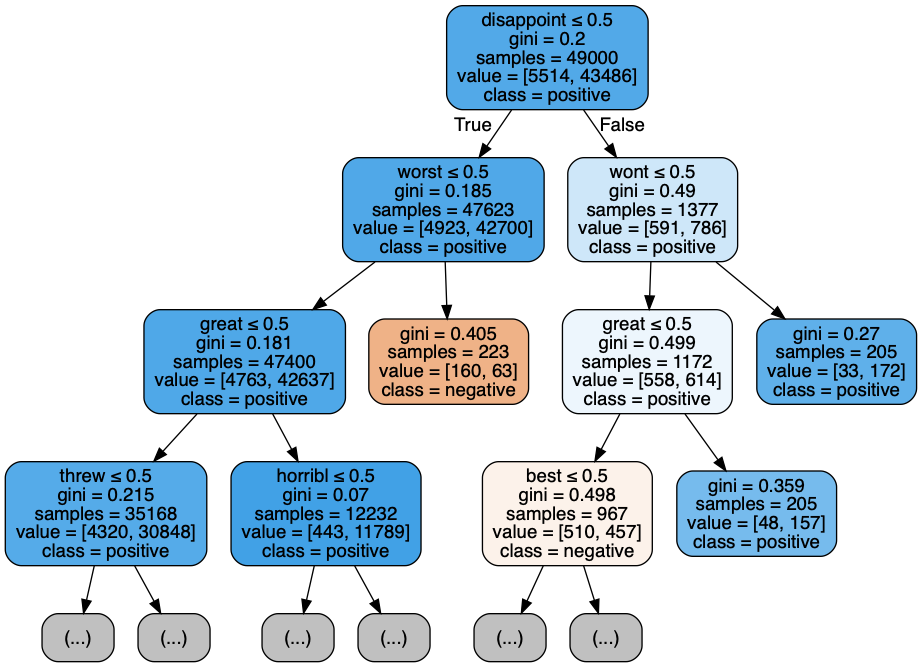

In [236]:
# Importing libraries
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
names = count_vector.get_feature_names()
target = ['negative','positive']

# Create DOT data
data = tree.export_graphviz(clf,out_file=None,class_names=target,feature_names = names, max_depth=3, filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

### Top 20 Features

In [241]:
imp_feat = clf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(imp_feat)[::-1][:20]
# Rearrange feature names so they match the sorted feature importances
names = count_vector.get_feature_names()
names = np.array(names)
print(names[indices])

['disappoint' 'worst' 'great' 'threw' 'terribl' 'horribl' 'best' 'return'
 'love' 'money' 'delici' 'bad' 'refund' 'aw' 'good' 'didnt' 'wont'
 'descript' 'wors' 'perfect']


### TFIDF

In [242]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_train = tfidf_vec.fit_transform(X_train)
tf_cv  = tfidf_vec.transform(X_cv)
tf_test = tfidf_vec.transform(X_test)


### Decision Tree Classifier (Training)

In [243]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

l=np.arange(1,1000,36)


Depths=[1, 5, 10, 50, 100, 500, 1000]
min_split= [5, 10, 100, 500]

param_grid = {'max_depth': Depths, 'min_samples_split': min_split}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1, pre_dispatch=2)
model.fit(tf_train, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

#Optimal value of min_samples_split
optimal_split = model.best_estimator_.min_samples_split
print("The optimal value of min split is : ",optimal_split)



Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of depth is :  50
The optimal value of min split is :  500


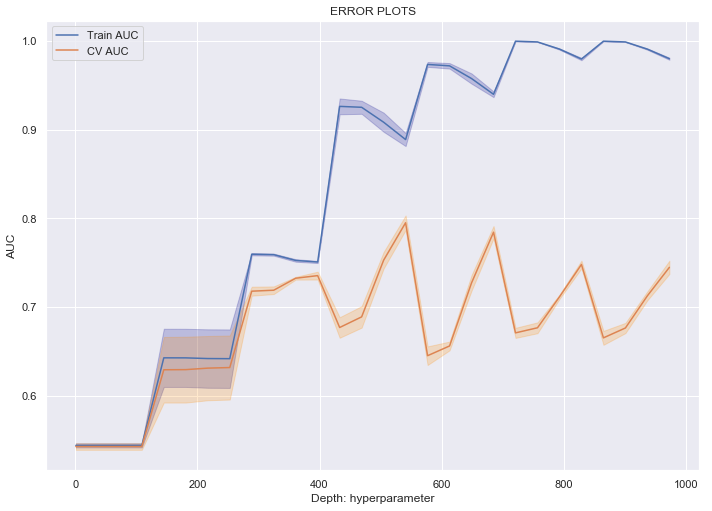

In [244]:
plt.plot(l, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

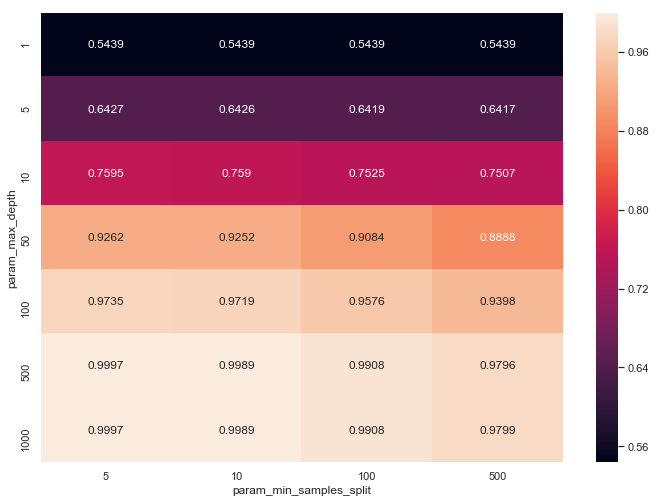

In [245]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')
plt.show()

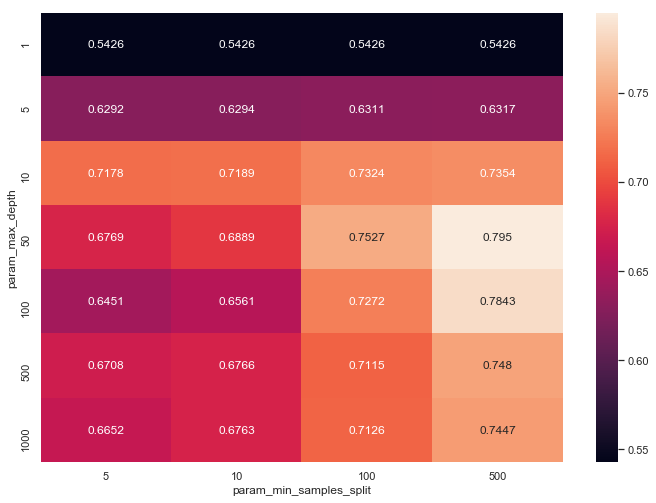

In [246]:
#Depths=[1, 5, 10, 50, 100, 500, 1000]
#min_split= [5, 10, 100, 500]
#param_grid = {'max_depth': Depths, 'min_samples_split': min_split}

df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()


In [247]:
results = pd.DataFrame(model.cv_results_)


In [248]:
results = results.sort_values(by='mean_test_score', ascending=False)

In [249]:
results[['mean_test_score', 'param_max_depth', 'param_min_samples_split']].round(3).head()

,mean_test_score,param_max_depth,param_min_samples_split
15,0.795,50,500
19,0.784,100,500
14,0.753,50,100
23,0.748,500,500
27,0.745,1000,500


In [250]:
model.best_score_

0.7949875063074477

### Observation
#### Max Depth = 50
#### Min Sample = 500

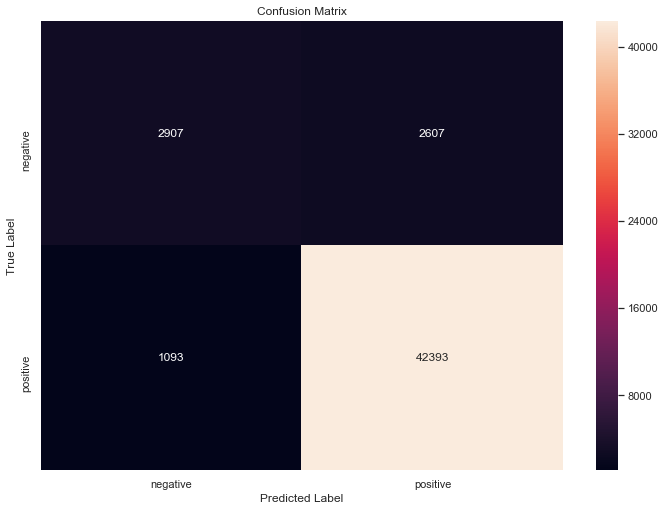

In [251]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
pred_train= model.predict(tf_train)
cm = confusion_matrix(y_train, pred_train)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation
#### The Confsuion Matrix for training shows that 2907 points are correclty classified as negative points, and 42393 points are classified correctly as positive points.

### Testing

In [252]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth= 50, min_samples_split= 500)
clf.fit(tf_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

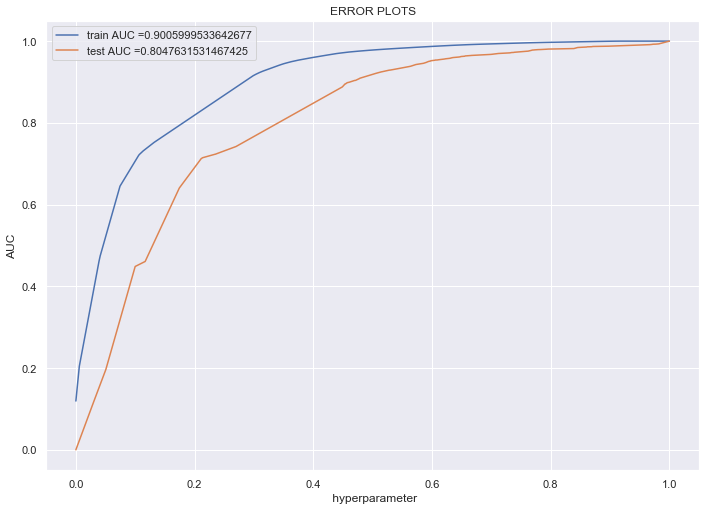

AUC value on test data: 0.8047631531467425


In [253]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(tf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(tf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel(" hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
pred = clf.predict(tf_test)
pred_prob = clf.predict_proba(tf_test)[:,1]
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

#### Train AUC = 0.90
#### Test AUC = 0.80

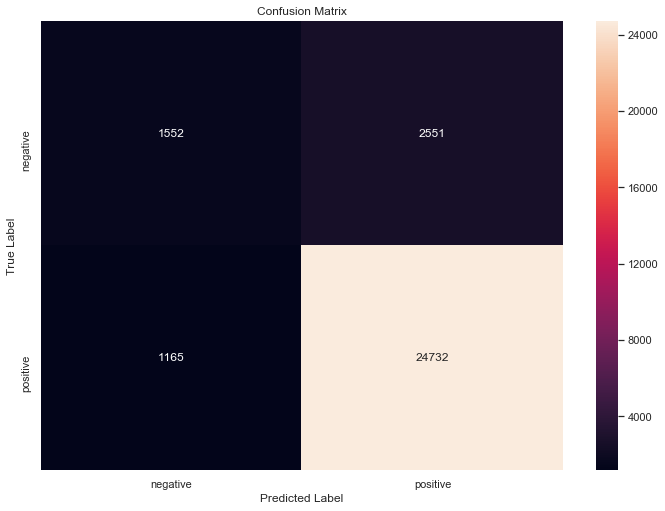

In [254]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
pred_test= model.predict(tf_test)
cm = confusion_matrix(y_test, pred_test)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation
#### The Confsuion Matrix for test shows that 1552 points are correclty classified as negative points, and 24732 points are classified correctly as positive points.

### Classification Report

In [255]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.58      0.38      0.46      4103
          1       0.91      0.96      0.93     25897

avg / total       0.86      0.88      0.87     30000



### Graphviz

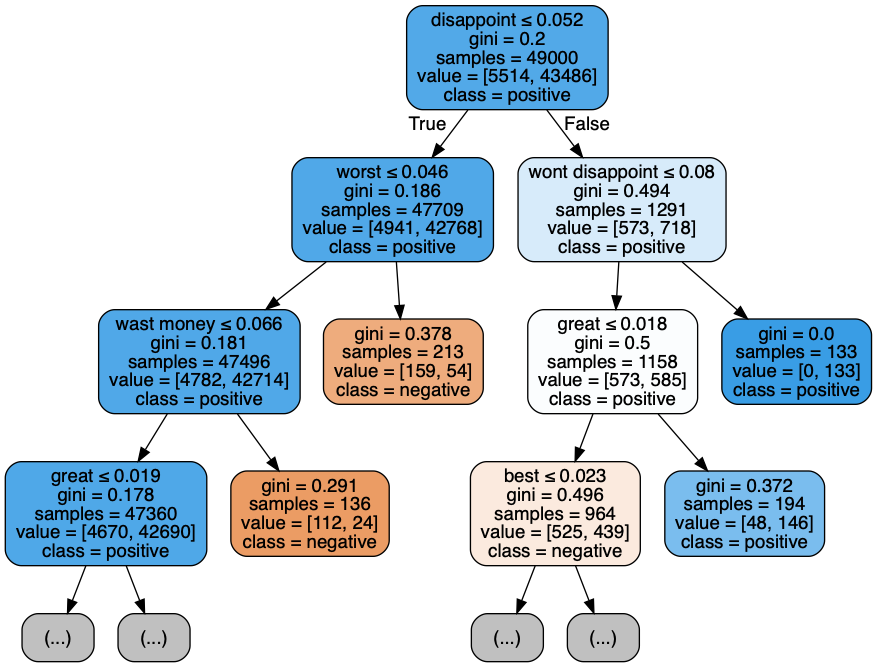

In [256]:
# Importing libraries
from sklearn import tree
import pydotplus
from IPython.display import Image
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
names = tfidf_vec.get_feature_names()
target = ['negative','positive']

# Create DOT data
data = tree.export_graphviz(clf,out_file=None,class_names=target,feature_names = names, max_depth=3, filled=True,rounded=True,special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(data)

# Show graph
Image(graph.create_png())

### Top 20 features

In [257]:
importances = clf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:20]
# Rearrange feature names so they match the sorted feature importances
names = tfidf_vec.get_feature_names()
names = np.array(names)
print(names[indices])

['disappoint' 'worst' 'great' 'wast money' 'return' 'best' 'bad' 'horribl'
 'terribl' 'threw' 'love' 'delici' 'refund' 'aw' 'wont buy'
 'wont disappoint' 'wors' 'bland' 'didnt' 'tast']


### AVG W2V

In [258]:
#w2v
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(type(list_of_sent))
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

<class 'list'>
witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [259]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [260]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(len(sent_vectors[0]))
print(type(sent_vectors))

364171
<class 'list'>


In [261]:
# create design matrix X and target vector y
X = np.array(sent_vectors[::]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [262]:
# split the data set into train and test
X_1, test_avgw2v, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
train_avgw2v, cv_avgw2v, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

### Decision Tree Classifier ( Training)

In [263]:
train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

l=np.arange(1,1000,36)


Depths=[1, 5, 10, 50, 100, 500, 1000]
min_split= [5, 10, 100, 500]

param_grid = {'max_depth': Depths, 'min_samples_split': min_split}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1, pre_dispatch=2)
model.fit(train_avgw2v, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

#Optimal value of min_samples_split
optimal_split = model.best_estimator_.min_samples_split
print("The optimal value of min split is : ",optimal_split)


Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of depth is :  10
The optimal value of min split is :  500


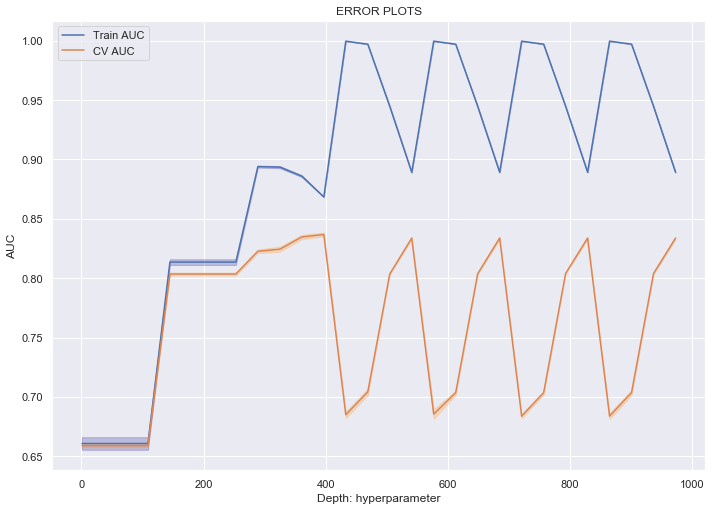

In [264]:
plt.plot(l, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

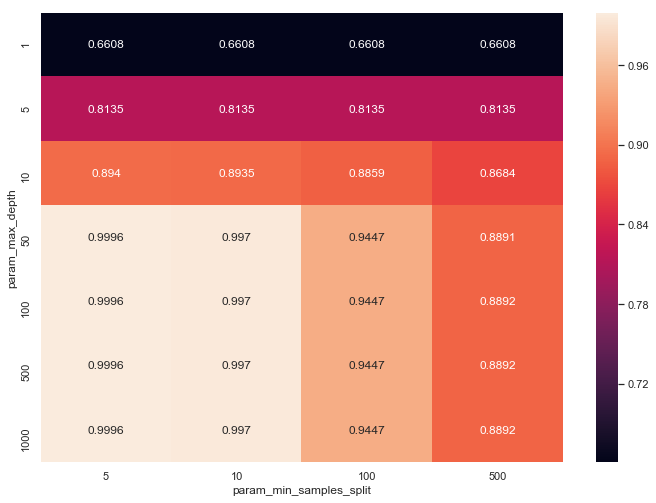

In [265]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')
plt.show()

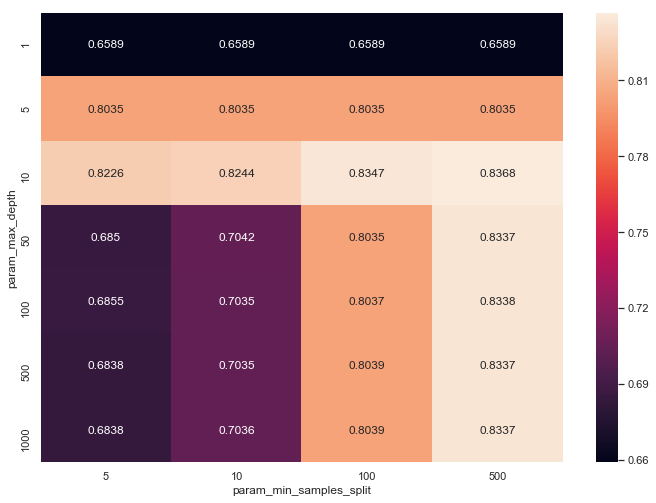

In [266]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()

In [267]:
results = pd.DataFrame(model.cv_results_)


In [268]:
results = results.sort_values(by='mean_test_score', ascending=False)

In [269]:
results[['mean_test_score', 'param_max_depth', 'param_min_samples_split']].round(3).head()

,mean_test_score,param_max_depth,param_min_samples_split
11,0.837,10,500
10,0.835,10,100
19,0.834,100,500
23,0.834,500,500
15,0.834,50,500


In [270]:
model.best_score_

0.8367852895811405

### Observation
#### Optimal depth = 10
#### Min Samples = 500

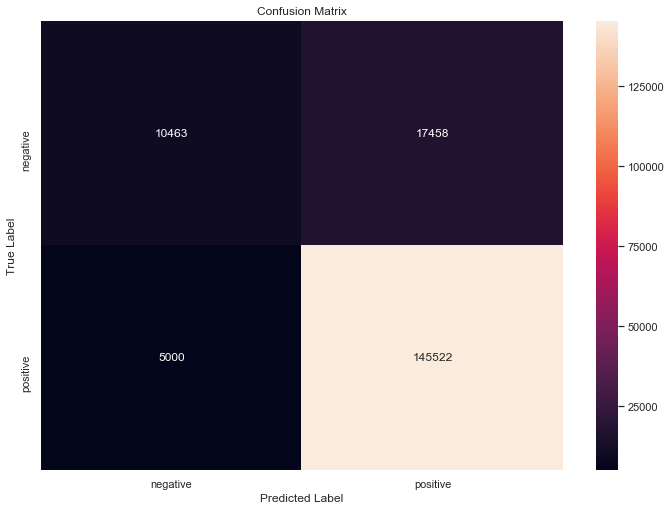

In [271]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
pred_train= model.predict(train_avgw2v)
cm = confusion_matrix(y_train, pred_train)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation
#### The Confsuion Matrix for training shows that 10463 points are correclty classified as negative points, and 145522 points are classified correctly as positive points.

### Testing

In [272]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth= 10, min_samples_split= 500)
clf.fit(train_avgw2v,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

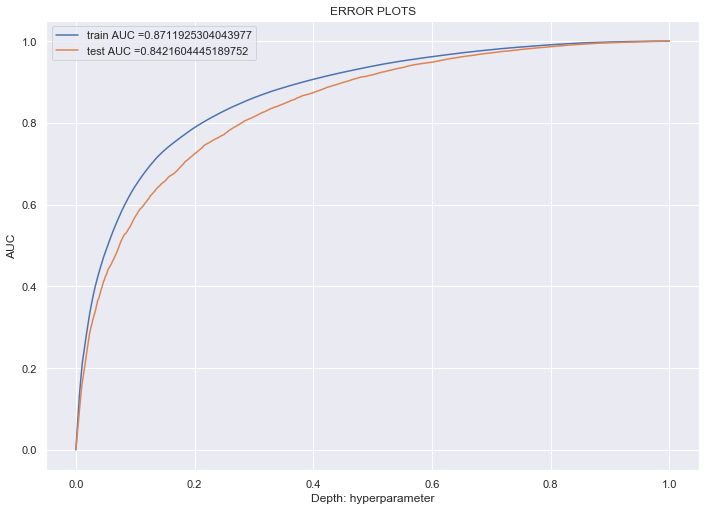

In [273]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(test_avgw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Observation
#### Test AUC = 0.82
#### Train AUC = 0.86

In [274]:
pred = clf.predict(test_avgw2v)
pred_prob = clf.predict_proba(test_avgw2v)[:,1]

### Confusion Matrix

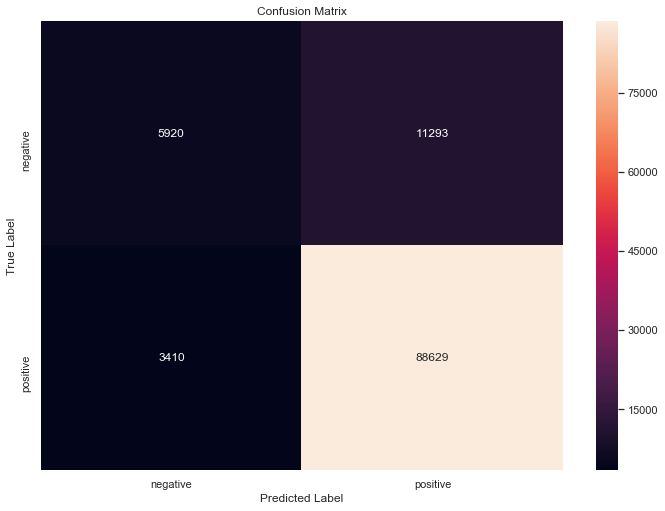

In [275]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation
#### The Confsuion Matrix for training shows that 5920 points are correclty classified as negative points, and 88629 points are classified correctly as positive points.

#### Classification Report

In [276]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))


             precision    recall  f1-score   support

          0       0.63      0.34      0.45     17213
          1       0.89      0.96      0.92     92039

avg / total       0.85      0.87      0.85    109252



### TFIDF W2V

In [277]:
#w2v
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(type(list_of_sent))
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])


<class 'list'>
witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [278]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [279]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [280]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in (list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [281]:

print(len(tfidf_sent_vectors))
print(np.shape(tfidf_sent_vectors))
print(type(tfidf_sent_vectors))

364171
(364171, 50)
<class 'list'>


In [282]:
# create design matrix X and target vector y
X = np.array(sent_vectors[::]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [283]:
# split the data set into train and test
X_1, test_tfidfw2v, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
train_tfidfw2v, cv_tfidfw2v, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

### Decision Tree Classifier (Training)

In [284]:
#Hyperparameter tuning
train_auc = []
cv_auc = []
train_auc_std = []
cv_auc_std = []

l=np.arange(1,1000,36)


Depths=[1, 5, 10, 50, 100, 500, 1000]
min_split= [5, 10, 100, 500]

param_grid = {'max_depth': Depths, 'min_samples_split': min_split}
model = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1, pre_dispatch=2)
model.fit(train_tfidfw2v, y_train)

train_auc = model.cv_results_['mean_train_score']
train_auc_std = model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

print("Model with best parameters :\n",model.best_estimator_)
# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("The optimal value of depth is : ",optimal_depth)

#Optimal value of min_samples_split
optimal_split = model.best_estimator_.min_samples_split
print("The optimal value of min split is : ",optimal_split)

Model with best parameters :
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The optimal value of depth is :  10
The optimal value of min split is :  500


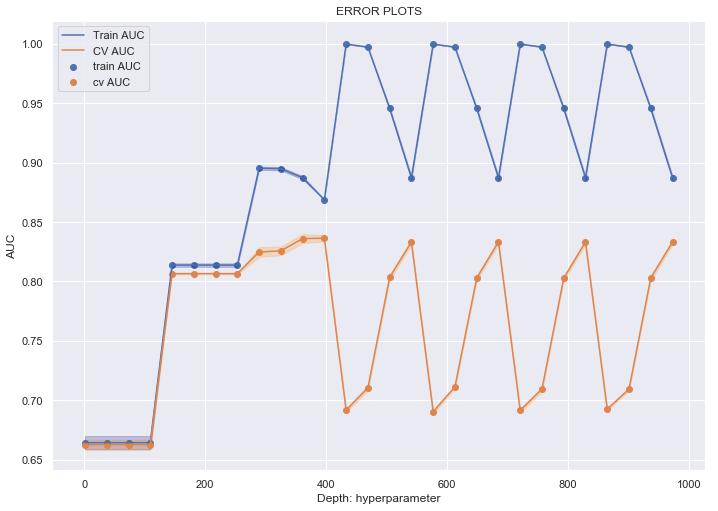

In [285]:
plt.plot(l, train_auc, label='Train AUC')
plt.scatter(l, train_auc, label='train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(l, cv_auc, label='CV AUC')
plt.scatter(l, cv_auc, label='cv AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(l,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


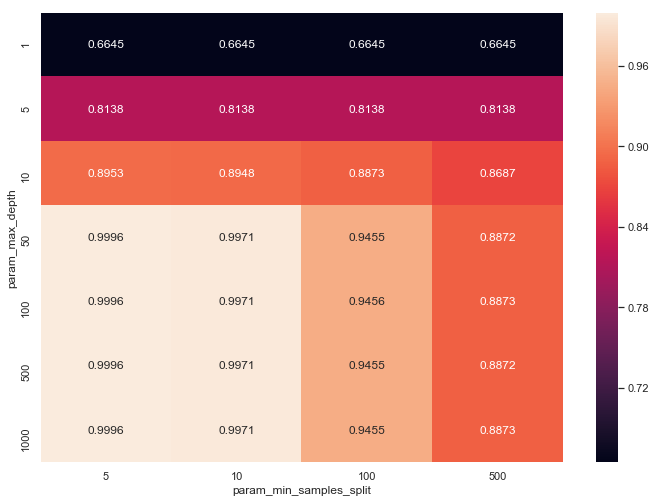

In [286]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')
plt.show()

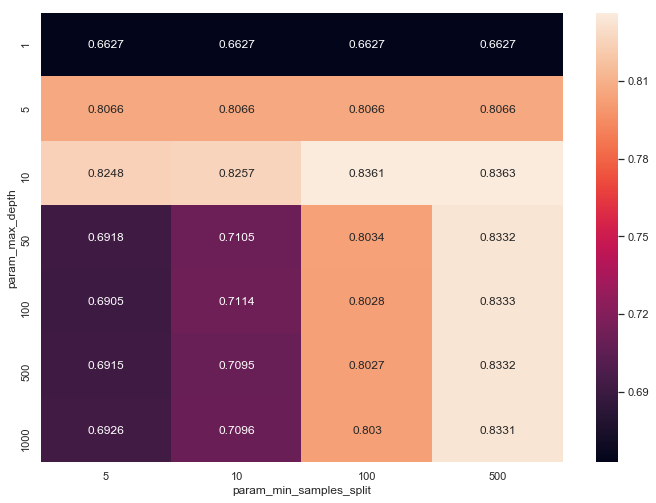

In [287]:
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_max_depth','param_min_samples_split']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
plt.show()

In [288]:
model.best_score_

0.8363487607901772

### Observation 
#### Optimal Depth = 10
#### Min Samples = 100

### Confusion Matrix

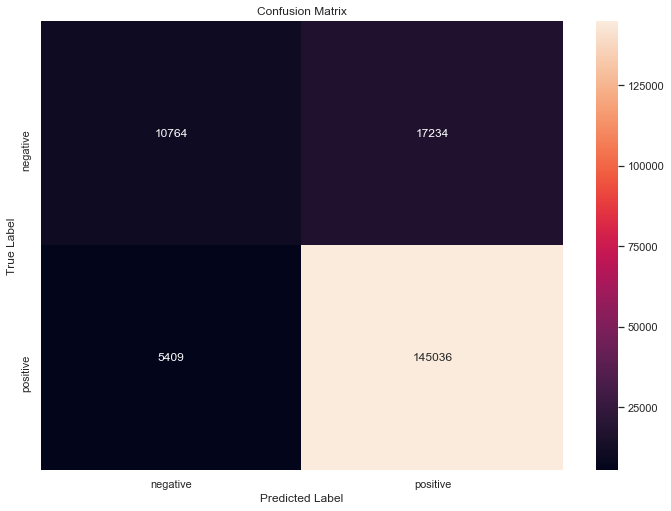

In [289]:
pred_train= model.predict(train_tfidfw2v)
cm = confusion_matrix(y_train, pred_train)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation
#### The Confsuion Matrix for training shows that 10764 points are correclty classified as negative points, and 145036 points are classified correctly as positive points.

### Testing

In [290]:
# DecisionTreeClassifier with Optimal value of depth
clf = DecisionTreeClassifier(max_depth= 100, min_samples_split= 10)
clf.fit(train_tfidfw2v,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

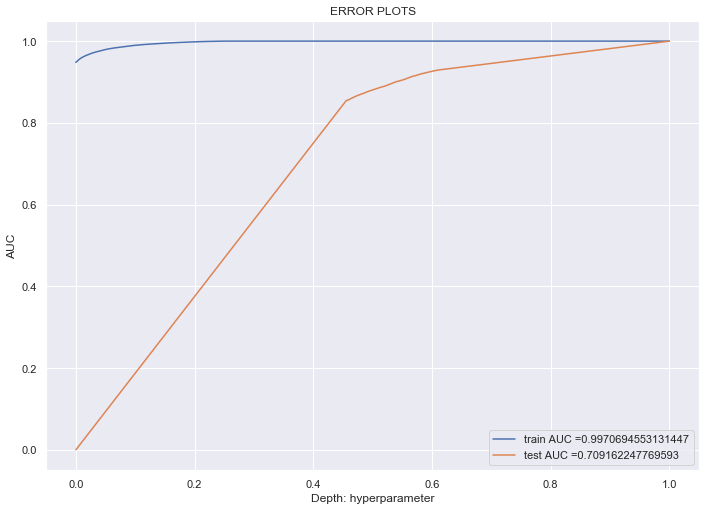

In [291]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(train_tfidfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(test_tfidfw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Observation 
#### Train AUC = 0.99
#### Test AUC = 0.70
#### *Model is overfitting for tfidf-w2v.*

### Confusion Matrix

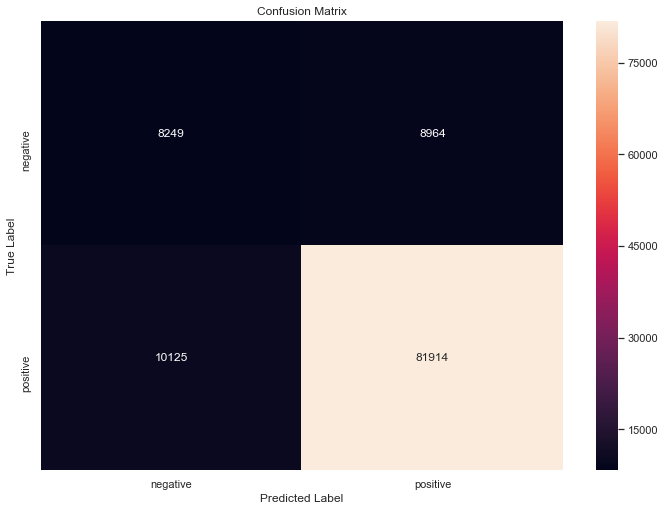

In [292]:
pred = clf.predict(test_tfidfw2v)
pred_prob = clf.predict_proba(test_tfidfw2v)[:,1]
cm = confusion_matrix(y_test, pred)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation
#### The Confsuion Matrix for training shows that 8249 points are correclty classified as negative points, and 81914 points are classified correctly as positive points.

#### Classification Report

In [293]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.45      0.48      0.46     17213
          1       0.90      0.89      0.90     92039

avg / total       0.83      0.83      0.83    109252



### Conclusion

In [294]:
#Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of the models
names =['Decision_Tree for BoW','Decision_Tree for TFIDF','Decision_Tree for Avg_Word2Vec', 'Decision_Tree for tfidf_Word2Vec']

# Values of optimal depth
optimal_depth1 = [50, 50, 10, 10]
optimal_split1 = [500,500,500,100]

# CV Accuracies
cv_auc = [0.80, 0.79,0.82,0.82]

# Test Accuracies
test_auc = [0.81,0.80,0.82,0.70]
numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Optimal Depth",optimal_depth1)
ptable.add_column("Optimal Min_split",optimal_split1)
ptable.add_column("CV AUC",cv_auc)
ptable.add_column("Test AUC",test_auc)

# Printing the Table
print(ptable)

+-------+----------------------------------+---------------+-------------------+--------+----------+
| S.NO. |              MODEL               | Optimal Depth | Optimal Min_split | CV AUC | Test AUC |
+-------+----------------------------------+---------------+-------------------+--------+----------+
|   1   |      Decision_Tree for BoW       |       50      |        500        |  0.8   |   0.81   |
|   2   |     Decision_Tree for TFIDF      |       50      |        500        |  0.79  |   0.8    |
|   3   |  Decision_Tree for Avg_Word2Vec  |       10      |        500        |  0.82  |   0.82   |
|   4   | Decision_Tree for tfidf_Word2Vec |       10      |        100        |  0.82  |   0.7    |
+-------+----------------------------------+---------------+-------------------+--------+----------+


##### *1. We get best test AUC on AvgW2V.*
##### *2. For BOW and Tfidf i have considered only 100000 data points.*
##### *3. Taken whole data for Avg-W2V and Tfidf-W2V to improve the AUC score.*
##### *4. For tfidif-w2v the model overfits a lot as there is huge difference between AUC test and train.*
